In [1]:
import sklearn.feature_extraction
sklearn.__version__

'0.19.1'

In [2]:
import pandas as pd
pd.__version__

u'0.20.3'

In [3]:
# Plotting defaults
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = 12.0, 5.0

In [4]:
# A plotting helper method
def plot_it(df,label_x,label_y):
    fig, ax = plt.subplots(subplot_kw={'axisbg':'#EEEEE5'})
    ax.grid(color='grey', linestyle='solid')
    df.T.plot(kind='bar', logx=True, rot=0, ax=ax, colormap='PiYG')
    ax.legend(loc=0, prop={'size':14})
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return ax

In [5]:
import os
basedir = './data'
filelist = os.listdir(basedir)
print(filelist)
df_list = []
for file in filelist:
    df = pd.read_csv(os.path.join(basedir,file), sep='|||', names=['raw_sql'], header=None)
    df['type'] = 'legit' if file.split('.')[0] == 'legit' else 'malicious'
    df_list.append(df)
dataframe = pd.concat(df_list, ignore_index=True)
dataframe.dropna(inplace=True)
print (dataframe['type'].value_counts())
dataframe.head()

['activeSQL.txt', 'legit.txt', 'MSSQL.txt', 'mySQL.txt', 'passiveSQL.txt', 'sql.txt', 'SQL_3.txt']
legit        4613
malicious    4085
Name: type, dtype: int64


C:\Users\18791\Anaconda3\envs\py\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,raw_sql,type
0,<!DOCTYPE html>,malicious
1,"<html lang=""en"">",malicious
2,<head>,malicious
3,"<meta charset=""utf-8"">",malicious
4,"<link rel=""dns-prefetch"" href=""https://assets-...",malicious


In [6]:
!which python

/c/Users/18791/Anaconda3/envs/py/python


In [9]:
# Use the SQLParse module: sqlparse is a non-validating SQL parser module for Python
# https://github.com/andialbrecht/sqlparse
!pip install sqlparse
import sqlparse
def parse_it(raw_sql):
    parsed = sqlparse.parse(unicode(raw_sql,'utf-8'))
    return [token._get_repr_name() for parse in parsed for token in parse.tokens if token._get_repr_name() != 'Whitespace']

dataframe['parsed_sql'] = dataframe['raw_sql'].map(lambda x: parse_it(x))

In [11]:
dataframe.head()

,raw_sql,type,parsed_sql
0,<!DOCTYPE html>,malicious,"[Comparison, Identifier, Comparison]"
1,"<html lang=""en"">",malicious,"[Comparison, Identifier, Comparison, Comparison]"
2,<head>,malicious,"[Comparison, Identifier, Comparison]"
3,"<meta charset=""utf-8"">",malicious,"[Comparison, Identifier, Keyword, Comparison, ..."
4,"<link rel=""dns-prefetch"" href=""https://assets-...",malicious,"[Comparison, Keyword, Comparison, Comparison, ..."


In [12]:
# Looking at the SQL tokens is 'kinda' interesting but sequences of tokens and transitions
# between tokens seems more meaningful so we're also going to compute sequences by
# computing NGrams for every SQL statement...
def ngrams(lst, N):
    ngrams = []
    for n in xrange(0,N):
        ngrams += zip(*(lst[i:] for i in xrange(n+1)))
    return [str(tuple) for tuple in ngrams]

In [13]:
dataframe['sequences'] = dataframe['parsed_sql'].map(lambda x: ngrams(x, 3))

In [14]:
# Helper method
def token_expansion(series, types):
    _tokens, _types = zip(*[(token,token_type) for t_list,token_type in zip(series,types) for token in t_list])
    return pd.Series(_tokens), pd.Series(_types)

In [15]:
dataframe['sequences']

0       [('Comparison',), ('Identifier',), ('Compariso...
1       [('Comparison',), ('Identifier',), ('Compariso...
2       [('Comparison',), ('Identifier',), ('Compariso...
3       [('Comparison',), ('Identifier',), ('Keyword',...
4       [('Comparison',), ('Keyword',), ('Comparison',...
5       [('Comparison',), ('Keyword',), ('Comparison',...
6       [('Comparison',), ('Keyword',), ('Comparison',...
7       [('Comparison',), ('Keyword',), ('Comparison',...
8       [('Comparison',), ('Keyword',), ('Comparison',...
9       [('Comparison',), ('Keyword',), ('Comparison',...
10      [('Comparison',), ('Keyword',), ('Comparison',...
11      [('Comparison',), ('Keyword',), ('Comparison',...
12      [('Comparison',), ('Keyword',), ('Comparison',...
13      [('Comparison',), ('Identifier',), ('Compariso...
14      [('Comparison',), ('Comparison',), ('Keyword',...
15      [('Comparison',), ('Keyword',), ('Comparison',...
16      [('Comparison',), ('Keyword',), ('Comparison',...
17      [('Com

In [19]:
# The data hacking repository has a simple stats module we're going to use

import data_hacking.simple_stats as ss

# Spin up our g_test class
g_test = ss.GTest()

# Here we'd like to see how various sql tokens and transitions are related.
# Is there an association with particular token sets and malicious SQL statements.
tokens, types = token_expansion(dataframe['sequences'], dataframe['type'])
df_ct, df_cd, df_stats = g_test.highest_gtest_scores(tokens, types, matches=0, N=0)

df_stats.sort_values('malicious_g', ascending=0).head(10)

# The table below shows raw counts, conditional distributions, expected counts, and g-test score.

,legit,malicious,legit_cd,malicious_cd,total_cd,legit_exp,legit_g,malicious_exp,malicious_g
"('Comparison',)",18363.0,14962.0,0.551028,0.448972,33325.0,21463.431599,-5729.728320,11861.568401,6948.652809
"('Comparison', 'Comparison')",415.0,2055.0,0.168016,0.831984,2470.0,1590.837991,-1115.302270,879.162009,3489.644555
"('Keyword', 'Comparison')",2616.0,2680.0,0.493958,0.506042,5296.0,3410.962753,-1388.301522,1885.037247,1886.018988
"('Identifier', 'Keyword', 'Comparison')",277.0,1063.0,0.206716,0.793284,1340.0,863.045712,-629.593384,476.954288,1703.839593
"('Operator', 'Comparison')",159.0,935.0,0.145338,0.854662,1094.0,704.605977,-473.417586,389.394023,1638.035447
"('Comparison', 'Identifier')",6660.0,4781.0,0.582117,0.417883,11441.0,7368.735812,-1347.007315,4072.264188,1534.228381
"('Keyword', 'Comparison', 'Identifier')",2307.0,2236.0,0.507814,0.492186,4543.0,2925.982588,-1096.666468,1617.017412,1449.398485
"('Comparison', 'Operator')",3425.0,2773.0,0.552598,0.447402,6198.0,3991.908449,-1049.200476,2206.091551,1268.410939
"('Identifier', 'Comparison', 'Comparison')",110.0,657.0,0.143416,0.856584,767.0,493.997060,-330.450824,273.002940,1153.956712
"('Comparison', 'Comparison', 'Comparison')",107.0,620.0,0.147180,0.852820,727.0,468.234502,-315.894047,258.765498,1083.508576


C:\Users\18791\Anaconda3\envs\py\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\18791\Anaconda3\envs\py\lib\site-packages\matplotlib\ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\18791\Anaconda3\envs\py\lib\site-packages\matplotlib\axes\_base.py:2923: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


(0.2, 1.4)

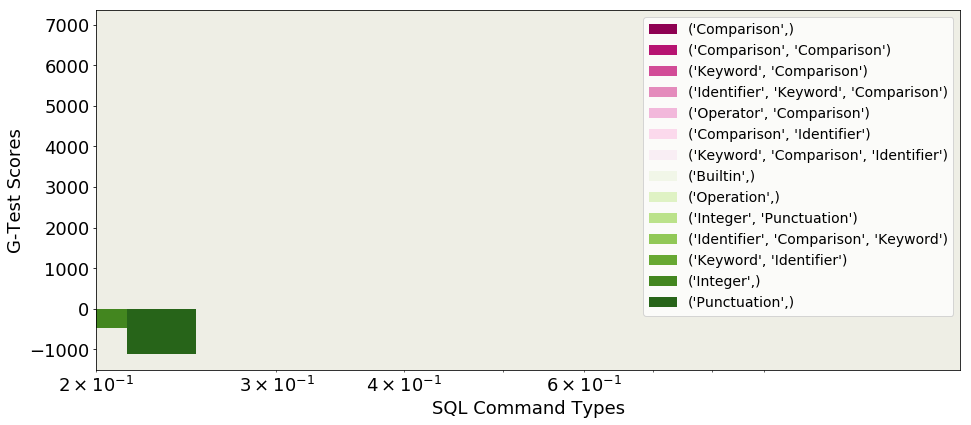

In [20]:
sorted_df = df_stats.sort_values('malicious_g', ascending=0)
naughty = sorted_df.head(7)
nice = sorted_df.tail(7).sort_values('malicious_g', ascending=0)
naughty_and_nice = pd.concat([naughty, nice])
ax = plot_it(naughty_and_nice[['malicious_g']],'SQL Command Types','G-Test Scores')
ax.set_xlim(.2, 1.4)

In [21]:
dataframe[dataframe['sequences'].map(lambda x: "('Single', 'Identifier')" in x)].head()

,raw_sql,type,parsed_sql,sequences


In [22]:

dataframe[dataframe['sequences'].map(lambda x: "('Punctuation',)" in x)].head()

,raw_sql,type,parsed_sql,sequences
368,<i>Branch:</i>,malicious,"[Comparison, Comparison, Punctuation, Comparis...","[('Comparison',), ('Comparison',), ('Punctuati..."
529,"<td id=""LC1"" class=""blob-code blob-code-inner ...",malicious,"[Comparison, Identifier, Comparison, Keyword, ...","[('Comparison',), ('Identifier',), ('Compariso..."
533,"<td id=""LC2"" class=""blob-code blob-code-inner ...",malicious,"[Comparison, Identifier, Comparison, Keyword, ...","[('Comparison',), ('Identifier',), ('Compariso..."
537,"<td id=""LC3"" class=""blob-code blob-code-inner ...",malicious,"[Comparison, Identifier, Comparison, Keyword, ...","[('Comparison',), ('Identifier',), ('Compariso..."
541,"<td id=""LC4"" class=""blob-code blob-code-inner ...",malicious,"[Comparison, Identifier, Comparison, Keyword, ...","[('Comparison',), ('Identifier',), ('Compariso..."


In [23]:
import math
from collections import Counter
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
dataframe['length'] = dataframe['parsed_sql'].map(lambda x: len(x))
dataframe['entropy'] = dataframe['raw_sql'].map(lambda x: entropy(x))
dataframe.head()

,raw_sql,type,parsed_sql,sequences,length,entropy
0,<!DOCTYPE html>,malicious,"[Comparison, Identifier, Comparison]","[('Comparison',), ('Identifier',), ('Compariso...",3,3.906891
1,"<html lang=""en"">",malicious,"[Comparison, Identifier, Comparison, Comparison]","[('Comparison',), ('Identifier',), ('Compariso...",4,3.625000
2,<head>,malicious,"[Comparison, Identifier, Comparison]","[('Comparison',), ('Identifier',), ('Compariso...",3,2.584963
3,"<meta charset=""utf-8"">",malicious,"[Comparison, Identifier, Keyword, Comparison, ...","[('Comparison',), ('Identifier',), ('Keyword',...",6,3.970573
4,"<link rel=""dns-prefetch"" href=""https://assets-...",malicious,"[Comparison, Keyword, Comparison, Comparison, ...","[('Comparison',), ('Keyword',), ('Comparison',...",5,4.581719


In [24]:
import numpy as np
def g_aggregate(sequence, name):
    try:
        g_scores = [df_stats.ix[item][name] for item in sequence]
    except KeyError:
        return 0
    return sum(g_scores)/len(g_scores) if g_scores else 0 # Average
dataframe['malicious_g'] = dataframe['sequences'].map(lambda x: g_aggregate(x, 'malicious_g'))
dataframe['legit_g'] = dataframe['sequences'].map(lambda x: g_aggregate(x, 'legit_g'))

C:\Users\18791\Anaconda3\envs\py\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [25]:
dataframe.head()

,raw_sql,type,parsed_sql,sequences,length,entropy,malicious_g,legit_g
0,<!DOCTYPE html>,malicious,"[Comparison, Identifier, Comparison]","[('Comparison',), ('Identifier',), ('Compariso...",3,3.906891,2785.017554,-2340.129251
1,"<html lang=""en"">",malicious,"[Comparison, Identifier, Comparison, Comparison]","[('Comparison',), ('Identifier',), ('Compariso...",4,3.625000,3144.706600,-2357.361880
2,<head>,malicious,"[Comparison, Identifier, Comparison]","[('Comparison',), ('Identifier',), ('Compariso...",3,2.584963,2785.017554,-2340.129251
3,"<meta charset=""utf-8"">",malicious,"[Comparison, Identifier, Keyword, Comparison, ...","[('Comparison',), ('Identifier',), ('Keyword',...",6,3.970573,2189.123708,-1760.772330
4,"<link rel=""dns-prefetch"" href=""https://assets-...",malicious,"[Comparison, Keyword, Comparison, Comparison, ...","[('Comparison',), ('Keyword',), ('Comparison',...",5,4.581719,3229.041492,-2295.865014


C:\Users\18791\Anaconda3\envs\py\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,u'SQL Statement Entropy')

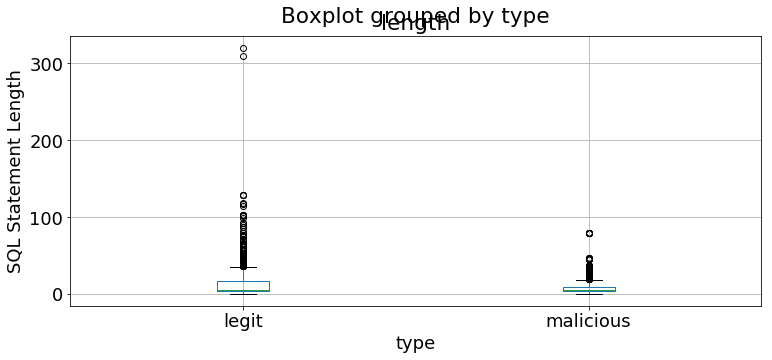

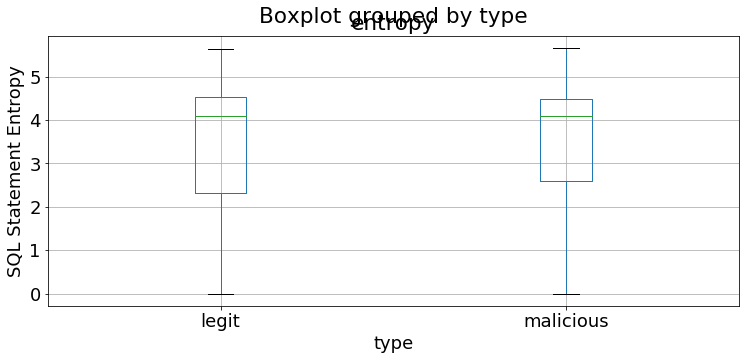

In [26]:
dataframe.boxplot('length','type')
plt.ylabel('SQL Statement Length')
dataframe.boxplot('entropy','type')
plt.ylabel('SQL Statement Entropy')

Text(0,0.5,u'SQL Statement Entropy')

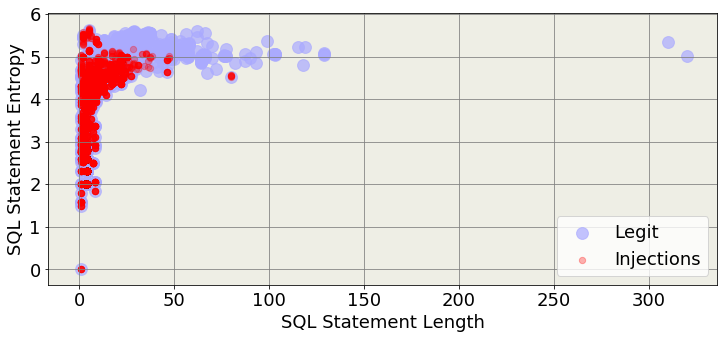

In [27]:
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
cond = dataframe['type'] == 'malicious'
evil = dataframe[cond]
legit = dataframe[~cond]
plt.scatter(legit['length'], legit['entropy'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['length'], evil['entropy'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.xlabel('SQL Statement Length')
plt.ylabel('SQL Statement Entropy')

Text(0.5,0,u'Malicious SQL G-Test Score')

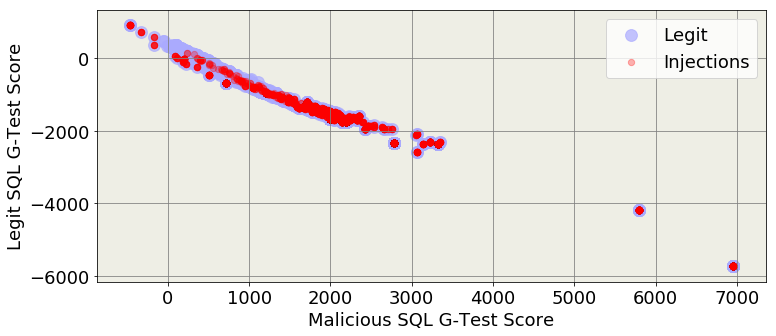

In [28]:
# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
plt.scatter(legit['malicious_g'], legit['legit_g'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(evil['malicious_g'], evil['legit_g'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.ylabel('Legit SQL G-Test Score')
plt.xlabel('Malicious SQL G-Test Score')

In [29]:

# In preparation for using scikit learn we're just going to use
# some handles that help take us from pandas land to scikit land

# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
X = dataframe.as_matrix(['length', 'entropy','legit_g','malicious_g'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(dataframe['type'].tolist())  # Yes, this is weird but it needs 
                                            # to be an np.array of strings

In [30]:
# Random Forest is a popular ensemble machine learning classifier.
# http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Trees in the forest

In [32]:
import sklearn.cross_validation
scores = sklearn.cross_validation.cross_val_score(clf, X, y, cv=10, n_jobs=4)
print scores

C:\Users\18791\Anaconda3\envs\py\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.4695752   0.76693456  0.91618829  0.9045977   0.94597701  0.97238205
  0.75719217  0.94361335  0.87917146  0.84579977]


In [33]:
# Wow 99% accurate! There is an issue though...
# Recall that we have ~13k 'malicious SQL statements and
# we only have about 1k 'legit' SQL statements, so we dive 
# in a bit and look at the predictive performance more deeply.

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, dataframe.index, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 83.14% (774/931)
legit/malicious: 16.86% (157/931)
malicious/legit: 13.84% (112/809)
malicious/malicious: 86.16% (697/809)


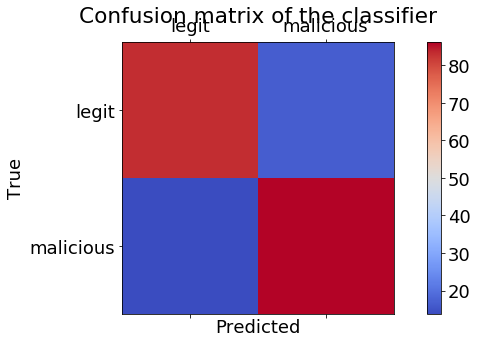

In [34]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'malicious']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print 'Confusion Matrix Stats'
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print "%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum())

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(cm, labels)

Confusion Matrix Stats
legit/legit: 90.98% (847/931)
legit/malicious: 9.02% (84/931)
malicious/legit: 85.78% (694/809)
malicious/malicious: 14.22% (115/809)


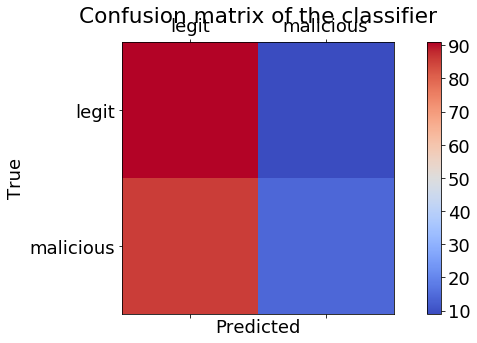

In [35]:

# Compute the precition probabilities and use them to mimimize our false positives
# Note: This is simply a trade off, it means we'll miss a few of the malicious
# ones but typically false alarms are a death blow to any new 'fancy stuff' so
# we definitely want to mimimize the false alarms.
y_probs = clf.predict_proba(X_test)[:,1]
thres = .9 # This can be set to whatever you'd like
y_pred[y_probs<thres] = 'legit'
y_pred[y_probs>=thres] = 'malicious'
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [36]:

# We can also look at what features the learning algorithm thought were the most important
importances = zip(['length', 'entropy', 'legit_g', 'malicious_g'], clf.feature_importances_)
importances

# From the list below we see our feature importance scores. There's a lot of feature selection,
# sensitivity study, etc stuff that you could do if you wanted at this point.

[('length', 0.17111626171666924),
 ('entropy', 0.48308049916477669),
 ('legit_g', 0.18588091600519346),
 ('malicious_g', 0.15992232311336052)]

In [37]:

# Now were going to just do some post analysis on how the ML algorithm performed.
# Lets look at the legit samples that were misclassified as malicious
test_set = dataframe.ix[index_test]
test_set['pred'] = y_pred
misclassified = test_set[(test_set['type']=='legit') & (test_set['pred']=='malicious')]
misclassified.head()

C:\Users\18791\Anaconda3\envs\py\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,raw_sql,type,parsed_sql,sequences,length,entropy,malicious_g,legit_g,pred
753,New repository,legit,"[Keyword, Identifier]","[('Keyword',), ('Identifier',), ('Keyword', 'I...",2,3.378783,201.372607,-35.589241,malicious
788,Your profile,legit,"[Identifier, Keyword]","[('Identifier',), ('Keyword',), ('Identifier',...",2,3.251629,509.819910,-474.159584,malicious
5018,"<td id=""LC965"" class=""blob-code blob-code-inne...",legit,"[Comparison, Identifier, Comparison, Keyword, ...","[('Comparison',), ('Identifier',), ('Compariso...",22,4.728612,884.419369,-615.821572,malicious
4870,"<td id=""LC928"" class=""blob-code blob-code-inne...",legit,"[Comparison, Identifier, Comparison, Keyword, ...","[('Comparison',), ('Identifier',), ('Compariso...",24,4.718754,884.465921,-618.840115,malicious
1138,"data-ga-click=""Repository, open with desktop, ...",legit,"[Keyword, Operator, Comparison, Comparison]","[('Keyword',), ('Operator',), ('Comparison',),...",4,4.436243,2357.436319,-1584.833951,malicious


In [42]:
# Discussion for how to use the resulting models.
# Typically Machine Learning comes in two phases
#    - Training of the Model
#    - Evaluation of new observations against the Model
# This notebook is about exploration of the data and training the model.
# After you have a model that you are satisfied with, just 'pickle' it
# at the end of the your training script and then in a separate
# evaluation script 'unpickle' it and evaluate/score new observations
# coming in (through a file, or ZeroMQ, or whatever...)
#
# In this case we'd have to pickle the RandomForest classifier.
# See 'test_it' below for how to use them in evaluation mode.


# test_it shows how to do evaluation, also fun for manual testing below :)
def test_it(sql):
    parsed_sql = parse_it(sql)
    ngram_list = ngrams(parsed_sql, 3)
    malicious_g = g_aggregate(ngram_list, 'malicious_g')
    legit_g = g_aggregate(ngram_list, 'legit_g')
    _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
    print '%-40s: %s' % (sql, clf.predict(_X)[0])

In [43]:
test_it('select * from employees')
test_it("'; exec master..xp_cmdshell")
test_it("'any 'x'='x'")
test_it('from dorseys mom xp_cmdshell biache')
test_it('select * from your_mom')

ValueError: Expected 2D array, got 1D array instead:
array=[   4.            3.46423459  108.3910141    42.59859085].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.